<a href="https://colab.research.google.com/github/pphongsopa/MQP2019/blob/master/Pavee/Deep_learning_for_CRR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
#Neural Network 
a = 20
model = nn.Sequential(
    nn.Linear(1, a),
    nn.ReLU(),
    nn.Linear(a, a),
    nn.Linear(a, 1)
)

In [0]:
#optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

In [0]:
#CRR function
def CRRAmericanOption(porc, n, T, S, K, r, sigma, q, tree):
  #type 'call' or 'put'
  # Variables and Initialization
  # n = Steps/height of bionomial tree
  # T = Time until maturity
  # S = Base price
  # K = Strike price
  # r = Interest
  # q = Dividend
  # sigma = volatility
  # tree = show option tree if True doesn't show if False
  
  dt = T/n #delta t for each step
  u = numpy.exp(sigma*numpy.sqrt(dt)) # Price multiplier if it goes up
  d = 1/u                             # Price multiplier if it does down
  p = (numpy.exp((r-q)*dt)-d)/(u-d)       # Formula for calculating probability for each price 
  
  # Binomial tree
  # Constructing the tree
  binomial_tree = numpy.zeros([n+1, n+1])
  
  # Initializing the tree
  for i in range(n+1):
      for j in range(i+1):
        binomial_tree[j, i] = S*(d**j)*u**(i-j)


  # Exercise tree
  # Constructing the tree
  exercise_tree = numpy.zeros([n+1, n+1])
  
  # Initializing the tree
  for i in range(n+1):
      for j in range(i+1):
        exercise_tree[j, i] = K
  
  # Options
  # Option value
  option = numpy.zeros([n+1, n+1])
  # From wiki page call option value is Max [ (Sn − K), 0 ]
  if porc is 'call': 
    option[:, n] = numpy.maximum(numpy.zeros(n+1), binomial_tree[:, n]-exercise_tree[:, n]) 
  
  if porc is 'put':
    option[:, n] = numpy.maximum(numpy.zeros(n+1), exercise_tree[:, n]-binomial_tree[:, n]) 

  # Calculatig the price at t = 0
  for i in numpy.arange(n-1, -1, -1):
     for j in numpy.arange(0, i+1):
        option[j, i] = numpy.exp(-r*dt)*(p*option[j, i+1]+(1-p)*option[j+1, i+1])

  if porc is 'call':   
    option[:, n] = numpy.maximum(option[:, n], binomial_tree[:, n]-exercise_tree[:, n]) 

  if porc is 'put':
    option[:, n] = numpy.maximum(option[:, n], exercise_tree[:, n]-binomial_tree[:, n]) 

        
  # Return value
  #if tree: 
  #  print(numpy.matrix(option))
  #  return option[0, 0]  
  # else: 
  return option[0, 0]

In [0]:
#loss function 
criterion = nn.MSELoss()

In [0]:
#training data

batch_size = 1

x_train = torch.randn(batch_size, 1)
y = CRRAmericanOption('call', 10, 100, 200, x_train, 0.05, 0.11, 0.1, False)
a = numpy.array([y])
y_train = torch.from_numpy(a)

In [67]:
x_train[0]

tensor([0.7513])

In [68]:
y_train

tensor([0.0040], dtype=torch.float64)

In [69]:
# Train the model

num_epochs = 100

for epoch in range(num_epochs):
   
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train.float())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 
                                                    num_epochs, loss.item()))

Epoch [10/100], Loss: 0.0406
Epoch [20/100], Loss: 0.0332
Epoch [30/100], Loss: 0.0271
Epoch [40/100], Loss: 0.0222
Epoch [50/100], Loss: 0.0181
Epoch [60/100], Loss: 0.0149
Epoch [70/100], Loss: 0.0122
Epoch [80/100], Loss: 0.0100
Epoch [90/100], Loss: 0.0082
Epoch [100/100], Loss: 0.0068


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


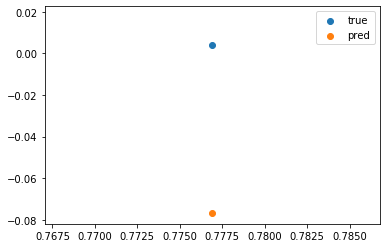

In [70]:
#test
x_ = torch.randn(1, 1)
y = CRRAmericanOption('call', 10, 100, 200, x_train, 0.05, 0.11, 0.1, False)
a = numpy.array([y])
y_ = torch.from_numpy(a)

plt.scatter(x_.detach().numpy(), y_.detach().numpy(), label='true')

y_pred = model(x_)
plt.scatter(x_.detach().numpy(), y_pred.detach().numpy(), label='pred')

plt.legend()